# COVID-19 and Weather Patterns

## Imports

- *os* for interfacing with the operating system
- *pathlib* for interfacing with the file system
- *zipfile* for managing archive files

- *numpy* for array processing
- *pandas* for tabular processing
- *tensorflow* for tensor processing
- *keras* for simplified tensor processing

- *matplotlib* for visualization
- *seaborn* for enhanced visualization

In [27]:
# Custom
import data_processing

# File System
import os
import json
from pathlib import Path
from zipfile import ZipFile
import pickle

# Processing
import gc
import numpy as np
import pandas as pd
from sympy import *
from sympy.geometry import *
import tensorflow
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

tensorflow.__version__

'2.7.0'

## Introduction

The goal of this work is to determine whether or not weather patterns should be considered as a meaningful supporting input when making predictions about new daily COVID-19 cases within a given geographical space. Using census, weather, and COVID-19 datasets provided by the Urban Sustain project, the authors attempt to quantify the correlation between particular weather patterns and COVID-19 transmission events.

## Defining Terms

***Urban Sustain Project*** - A joint effort between researchers at Colorado State University, Arizona State University, the University of California-Irvine, and the University of Maryland – Baltimore County.

## Loading Data

**DEVELOPER NOTE:** Download the five required datasets from Urban Sustain and place them in the cloned repository at ```./data/```. These datasets are also available at a shared OneDrive folder. This logic expects that these files exist at relative path ```../data/``` with respect to this notebook.

We'll begin by defining a path to our data directory and a list of the datasets that we expect to find there.

In [28]:
DATA_PATH = '../data/' # Point this constant to the location of your data archive files

EXPECTED_DATASETS = [
    'county_total_population.Colorado.zip',
    'covid_county.Colorado.zip',
    'neon_2d_wind.Colorado.zip',
    'neon_barometric_pressure.Colorado.zip',
    'neon_single_asp_air_temperature.Colorado.zip'
]

Next, we will attempt to extract each of these archived datasets into a dedicated subdirectory within the given data directory.

In [29]:
# For each listed dataset string in the EXPECTED_DATASETS constant
for datasetName in EXPECTED_DATASETS:
    try:
        # Open the given archive file
        with ZipFile(DATA_PATH + datasetName, 'r') as currentZip:
            # Build the target directory path for extracted data
            datasetNameTokens = datasetName.split('.')
            datasetNameTokens.remove('zip')
            targetDirectory = DATA_PATH + '.'.join(datasetNameTokens)
            
            # If the target directory doesn't exist, create it
            if not os.path.exists(targetDirectory):
                Path(targetDirectory).mkdir()
            
            # Extract all data from the archive file to the target directory
            currentZip.extractall(targetDirectory)
    except FileNotFoundError:
        print("Unable to open " + datasetName + " at path " + DATA_PATH + datasetName)

## File Information

Four of the five datasets referenced in this work relate geospatial information to particular events as they occur over time Each is provided by the Urban Sustain project and employs a similar file structure.

- data.json
- fieldLabels.json
- linkedGeometry.json
- README.txt


#### New York Times COVID-19 County Dataset

The included COVID-19 County dataset 

In [30]:
covidDataFrame = pd.io.json.read_json('../data/covid_county.Colorado/data.json')
covidDataFrame.sample(5)

,_id,GISJOIN,epoch_time,dateString,county,state,totalCaseCount,newCaseCount,totalDeathCount,newDeathCount
9217,{'$oid': '615fc625bf06594c4cad6643'},G0800270,{'$numberLong': '1618207200000'},4/12/21,Custer,Colorado,177,0,1,0
7637,{'$oid': '615fc624bf06594c4cad6042'},G0800230,{'$numberLong': '1593410400000'},6/29/20,Costilla,Colorado,20,0,0,0
31323,{'$oid': '615fc627bf06594c4cadbfa8'},G0800990,{'$numberLong': '1600322400000'},9/17/20,Prowers,Colorado,92,0,0,0
14118,{'$oid': '615fc625bf06594c4cad78dc'},G0800430,{'$numberLong': '1598335200000'},8/25/20,Fremont,Colorado,152,6,0,0
15050,{'$oid': '615fc625bf06594c4cad7d6e'},G0800470,{'$numberLong': '1591250400000'},6/4/20,Gilpin,Colorado,4,0,0,0


In [31]:
covidLabelsFrame = pd.io.json.read_json('../data/covid_county.Colorado/fieldLabels.json')
covidLabelsFrame.sample(5)

,name,label
4,totalCaseCount,Total Case Count
2,totalDeathCount,Total Death Count
3,newCaseCount,New Case Count
1,newDeathCount,New Death Count
0,epoch_time,Date


In [32]:
covidGeometryFrame = pd.io.json.read_json('../data/covid_county.Colorado/linkedGeometry.json')
covidGeometryFrame.sample(5)

,_id,type,geometry,properties,GISJOIN
12,{'$oid': '604964ecfed2e95d6b68b682'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.154...","{'STATEFP10': '08', 'COUNTYFP10': '023', 'COUN...",G0800230
37,{'$oid': '604964ecfed2e95d6b68b680'},Feature,"{'type': 'Polygon', 'coordinates': [[[-103.707...","{'STATEFP10': '08', 'COUNTYFP10': '073', 'COUN...",G0800730
8,{'$oid': '604964eefed2e95d6b68b846'},Feature,"{'type': 'Polygon', 'coordinates': [[[-106.191...","{'STATEFP10': '08', 'COUNTYFP10': '015', 'COUN...",G0800150
56,{'$oid': '604964eefed2e95d6b68b9c7'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.568...","{'STATEFP10': '08', 'COUNTYFP10': '111', 'COUN...",G0801110
15,{'$oid': '604964ecfed2e95d6b68b67d'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.500...","{'STATEFP10': '08', 'COUNTYFP10': '029', 'COUN...",G0800290


#### NEON 2D Wind Dataset

In [33]:
windDataFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/data.json')
windDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,windSpeedMean,windSpeedMinimum,windSpeedMaximum,windSpeedVariance,windSpeedNumPts,windSpeedExpUncert,windSpeedStdErMean,windSpeedFinalQF,windDirMean,windDirVariance,windDirNumPts,windDirExpUncert,windDirStdErMean,windDirFinalQF
384249,{'$oid': '60cbc08b51c1683b462c7196'},CPER_DP1.00001.001_000.020,{'$numberLong': '1591898400000'},2020-06-11T18:00:00Z,2020-06-11T18:30:00Z,3.17,0.00,7.79,2.48,1800,0.25,0.04,0,301.76,1496.39,1800,0.07,0.03,0
212759,{'$oid': '60cbc07651c1683b462a1b50'},CPER_DP1.00001.001_000.010,{'$numberLong': '1498843800000'},2017-06-30T17:30:00Z,2017-06-30T18:00:00Z,0.72,0.01,1.99,0.14,1800,0.04,0.01,0,152.64,4672.16,1800,0.07,0.03,1
291276,{'$oid': '60cbc06651c1683b46283e9d'},CPER_DP1.00001.001_000.020,{'$numberLong': '1415518200000'},2014-11-09T07:30:00Z,2014-11-09T08:00:00Z,1.63,0.16,3.06,0.30,1800,0.06,0.01,0,358.96,770.86,1800,0.07,0.06,1
1264729,{'$oid': '60cbc03d51c1683b4623e311'},STER_DP1.00001.001_000.020,{'$numberLong': '1457235000000'},2016-03-06T03:30:00Z,2016-03-06T04:00:00Z,3.35,1.69,5.29,0.31,1800,0.12,0.01,0,165.41,55.33,1800,0.19,0.00,0
118185,{'$oid': '60cbc65651c1683b46cdfde0'},COMO_DP1.00001.001_200.000,{'$numberLong': '1551771000000'},2019-03-05T07:30:00Z,2019-03-05T08:00:00Z,1.14,0.01,4.80,0.45,1800,0.10,0.02,0,349.00,6107.69,1800,0.07,0.05,0


In [34]:
windLabelsFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/fieldLabels.json')
windLabelsFrame.sample(5)

,name,label
23,windSpeedSensorErrorPassQM,Wind speed quality metric that summarizes the ...
45,windDirGapPassQM,Wind direction quality metric that summarizes ...
38,windDirPersistenceFailQM,Wind direction quality metric that summarizes ...
22,windSpeedSensorErrorFailQM,Wind speed quality metric that summarizes the ...
6,windSpeedVariance,Variance in wind speed


In [35]:
windGeometryFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/linkedGeometry.json')
windGeometryFrame.sample(5)

,_id,type,geometry,properties,site
14,{'$oid': '60cbcf5eed5577c25c205268'},Feature,"{'type': 'Point', 'coordinates': [-102.450966,...","{'HOR.VER': '200.000', 'name': 'CFGLOC101251',...",ARIK_DP1.00001.001_200.000
7,{'$oid': '60cbcf5eed5577c25c205296'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC109359',...",NIWO_DP1.00001.001_000.030
1,{'$oid': '60cbcf5eed5577c25c205233'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.040', 'name': 'CFGLOC100675',...",RMNP_DP1.00001.001_000.040
8,{'$oid': '60cbcf5eed5577c25c20520c'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC100242',...",CPER_DP1.00001.001_000.020
9,{'$oid': '60cbcf5eed5577c25c20520d'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100245',...",CPER_DP1.00001.001_000.030


#### NEON Barometric Pressure Dataset

In [36]:
pressureDataFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/data.json')
pressureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,staPresMean,staPresMinimum,staPresMaximum,staPresVariance,staPresNumPts,staPresExpUncert,staPresStdErMean,staPresFinalQF,corPres,corPresExpUncert,corPresFinalQF
443686,{'$oid': '60c78ce0c8cb4f3f3b22b7e2'},STER_DP1.00004.001,{'$numberLong': '1539880200000'},2018-10-18T16:30:00Z,2018-10-18T17:00:00Z,86.32467,86.30923,86.34880,0.00008,180,0.01725,0.00066,0,101.20078,0.10237,0
430139,{'$oid': '60c78cdec8cb4f3f3b2282aa'},STER_DP1.00004.001,{'$numberLong': '1514746800000'},2017-12-31T19:00:00Z,2017-12-31T19:30:00Z,87.31003,87.28903,87.32904,0.00011,180,0.01727,0.00076,0,104.26540,0.12766,0
404826,{'$oid': '60c78cdbc8cb4f3f3b221e36'},STER_DP1.00004.001,{'$numberLong': '1467270000000'},2016-06-30T07:00:00Z,2016-06-30T07:30:00Z,86.56702,86.55058,86.58859,0.00014,180,0.01729,0.00087,0,101.35992,0.10702,0
11244,{'$oid': '60c78aaac8cb4f3f3be1972c'},ARIK_DP1.00004.001,{'$numberLong': '1511330400000'},2017-11-22T06:00:00Z,2017-11-22T06:30:00Z,88.92638,88.90893,88.93894,0.00007,180,0.01725,0.00064,0,103.04201,0.08898,0
84267,{'$oid': '60c78b03c8cb4f3f3bebe37b'},COMO_DP1.00004.001,{'$numberLong': '1521365400000'},2018-03-18T09:30:00Z,2018-03-18T10:00:00Z,69.65198,69.63722,69.66730,0.00010,180,0.01726,0.00074,0,101.33148,0.54412,0


In [37]:
pressureLabelsFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/fieldLabels.json')
pressureLabelsFrame.sample(5)

,name,label
0,epoch_time,Date
30,staPresValidCalNAQM,Station pressure quality metric that summarize...
10,staPresRangeFailQM,Station pressure quality metric that summarize...
37,corPresTempQF,Corrected pressure quality flag that assesses ...
32,staPresBetaQM,Station pressure quality metric detailing the ...


In [38]:
pressureGeometryFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/linkedGeometry.json')
pressureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
6,{'$oid': '60c78a9d230c7f49850c20a5'},Feature,"{'type': 'Point', 'coordinates': [-102.450966,...","{'site': 'ARIK_DP1.00004.001', 'name': 'neon_b...",ARIK_DP1.00004.001
5,{'$oid': '60c78a9d230c7f49850c20e3'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'site': 'STER_DP1.00004.001', 'name': 'neon_b...",STER_DP1.00004.001
2,{'$oid': '60c78a9d230c7f49850c20b0'},Feature,"{'type': 'Point', 'coordinates': [-105.544602,...","{'site': 'COMO_DP1.00004.001', 'name': 'neon_b...",COMO_DP1.00004.001
4,{'$oid': '60c78a9d230c7f49850c20b1'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'site': 'CPER_DP1.00004.001', 'name': 'neon_b...",CPER_DP1.00004.001
0,{'$oid': '60c78a9d230c7f49850c20dc'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'site': 'RMNP_DP1.00004.001', 'name': 'neon_b...",RMNP_DP1.00004.001


#### NEON Air Temperature

In [39]:
temperatureDataFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/data.json')
temperatureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,tempSingleMean,tempSingleMinimum,tempSingleMaximum,tempSingleVariance,tempSingleNumPts,tempSingleExpUncert,tempSingleStdErMean,finalQF
890089,{'$oid': '60cbd52f0fc3818c81097553'},RMNP_DP1.00002.001_000.040,{'$numberLong': '1524960000000'},2018-04-29T00:00:00Z,2018-04-29T00:30:00Z,9.6170,9.1877,9.8605,0.0231,1800,0.1387,0.0036,0
87586,{'$oid': '60cbd8140fc3818c8161050b'},COMO_DP1.00002.001_200.000,{'$numberLong': '1496340000000'},2017-06-01T18:00:00Z,2017-06-01T18:30:00Z,12.6128,10.9652,14.6488,0.8196,1800,0.1468,0.0213,0
743897,{'$oid': '60cbd5320fc3818c8109d78d'},RMNP_DP1.00002.001_000.020,{'$numberLong': '1536685200000'},2018-09-11T17:00:00Z,2018-09-11T17:30:00Z,21.7179,20.8234,22.9984,0.1813,1800,0.1456,0.0100,0
727693,{'$oid': '60cbd5280fc3818c8108d499'},RMNP_DP1.00002.001_000.020,{'$numberLong': '1504900800000'},2017-09-08T20:00:00Z,2017-09-08T20:30:00Z,18.3687,17.6121,20.6681,0.6177,1800,0.1479,0.0185,0
512528,{'$oid': '60cbd8970fc3818c81708f89'},NIWO_DP1.00002.001_000.020,{'$numberLong': '1556377200000'},2019-04-27T15:00:00Z,2019-04-27T15:30:00Z,-2.9045,-3.2098,-2.6333,0.0243,1470,0.1333,0.0041,1


In [40]:
temperatureLabelsFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/fieldLabels.json')
temperatureLabelsFrame.sample(5)

,name,label
17,stepPassQM,Quality metric that summarizes the passed outc...
23,gapPassQM,Quality metric that summarizes the passed outc...
26,spikePassQM,Quality metric that summarizes the passed outc...
27,spikeNAQM,Quality metric that summarizes when the spike ...
19,nullFailQM,Quality metric that summarizes the failed outc...


In [41]:
temperatureGeometryFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json')
temperatureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
10,{'$oid': '60cbd3907adbc5ff35cc41a5'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC100241',...",CPER_DP1.00002.001_000.020
2,{'$oid': '60cbd3907adbc5ff35cc41cc'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.040', 'name': 'CFGLOC100674',...",RMNP_DP1.00002.001_000.040
13,{'$oid': '60cbd3907adbc5ff35cc41a3'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100018',...",STER_DP1.00002.001_000.030
9,{'$oid': '60cbd3907adbc5ff35cc41a6'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100244',...",CPER_DP1.00002.001_000.030
5,{'$oid': '60cbd3907adbc5ff35cc421b'},Feature,"{'type': 'Point', 'coordinates': [-105.544602,...","{'HOR.VER': '200.000', 'name': 'CFGLOC101559',...",COMO_DP1.00002.001_200.000


### U.S. Census Total County Population Dataset

In [42]:
populationDataFrame = pd.io.json.read_json('../data/county_total_population.Colorado/data.json')
populationDataFrame

,_id,GISJOIN,STATE,STATEFP,STATENH,COUNTY,COUNTYFP,COUNTYNH,1980_total_population,1990_total_population,2000_total_population,2010_total_population
0,{'$oid': '607d4c2708e81eceb6b6e384'},G0800010,Colorado,8,80,Adams County,1,10,245944,265038,363857,441603
1,{'$oid': '607d4c2708e81eceb6b6e385'},G0800030,Colorado,8,80,Alamosa County,3,30,11799,13617,14966,15445
2,{'$oid': '607d4c2708e81eceb6b6e386'},G0800050,Colorado,8,80,Arapahoe County,5,50,293621,391511,487967,572003
3,{'$oid': '607d4c2708e81eceb6b6e387'},G0800070,Colorado,8,80,Archuleta County,7,70,3664,5345,9898,12084
4,{'$oid': '607d4c2708e81eceb6b6e388'},G0800090,Colorado,8,80,Baca County,9,90,5419,4556,4517,3788
...,...,...,...,...,...,...,...,...,...,...,...,...
58,{'$oid': '607d4c2708e81eceb6b6e3bf'},G0801170,Colorado,8,80,Summit County,117,1170,8848,12881,23548,27994
59,{'$oid': '607d4c2708e81eceb6b6e3c4'},G0801190,Colorado,8,80,Teller County,119,1190,8034,12468,20555,23350
60,{'$oid': '607d4c2708e81eceb6b6e3c3'},G0801210,Colorado,8,80,Washington County,121,1210,5304,4812,4926,4814
61,{'$oid': '607d4c2708e81eceb6b6e3c2'},G0801230,Colorado,8,80,Weld County,123,1230,123438,131821,180936,252825


In [43]:
populationLabelsFrame = pd.io.json.read_json('../data/county_total_population.Colorado/fieldLabels.json')
populationLabelsFrame

""


In [44]:
populationGeometryFrame = pd.io.json.read_json('../data/county_total_population.Colorado/linkedGeometry.json')
populationGeometryFrame

,_id,type,geometry,properties,GISJOIN
0,{'$oid': '604964ecfed2e95d6b68b676'},Feature,"{'type': 'Polygon', 'coordinates': [[[-104.961...","{'STATEFP10': '08', 'COUNTYFP10': '001', 'COUN...",G0800010
1,{'$oid': '604964ecfed2e95d6b68b684'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.457...","{'STATEFP10': '08', 'COUNTYFP10': '003', 'COUN...",G0800030
2,{'$oid': '604964eefed2e95d6b68bb16'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '005', 'COUN...",G0800050
3,{'$oid': '604964eefed2e95d6b68b9c8'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.128...","{'STATEFP10': '08', 'COUNTYFP10': '007', 'COUN...",G0800070
4,{'$oid': '604964eefed2e95d6b68b83d'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.747...","{'STATEFP10': '08', 'COUNTYFP10': '009', 'COUN...",G0800090
...,...,...,...,...,...
59,{'$oid': '604964ecfed2e95d6b68b677'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.924...","{'STATEFP10': '08', 'COUNTYFP10': '117', 'COUN...",G0801170
60,{'$oid': '604964eefed2e95d6b68b840'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.329...","{'STATEFP10': '08', 'COUNTYFP10': '119', 'COUN...",G0801190
61,{'$oid': '604964eefed2e95d6b68b9c5'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.779...","{'STATEFP10': '08', 'COUNTYFP10': '121', 'COUN...",G0801210
62,{'$oid': '604964eefed2e95d6b68b9c3'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '123', 'COUN...",G0801230


## Data Exploration

c:\users\jfizzle\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='newCaseCount', ylabel='Density'>

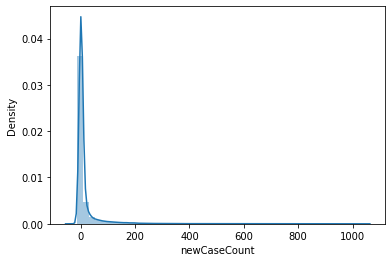

In [45]:
sns.distplot(covidDataFrame.newCaseCount)

c:\users\jfizzle\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tempSingleMean', ylabel='Density'>

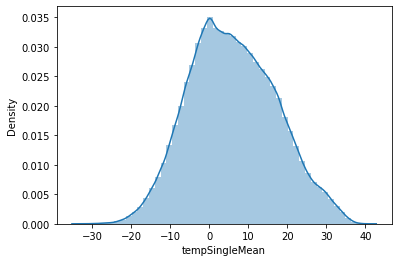

In [46]:
sns.distplot(temperatureDataFrame.tempSingleMean)

#### Garbage Collection

In [47]:
del covidDataFrame
del covidLabelsFrame
del covidGeometryFrame

del windDataFrame
del windLabelsFrame
del windGeometryFrame

del pressureDataFrame
del pressureLabelsFrame
del pressureGeometryFrame

del temperatureDataFrame
del temperatureLabelsFrame
del temperatureGeometryFrame

del populationDataFrame
del populationLabelsFrame
del populationGeometryFrame

gc.collect()

105

## Preprocessing

#### Flatten Frames

In [48]:
flattenedCovidDataFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/data.json'))))
flattenedCovidGeometryFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/linkedGeometry.json'))))

flattenedWindDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/data.json'))))
flattenedWindGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/linkedGeometry.json'))))

flattenedPressureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/data.json'))))
flattenedPressureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/linkedGeometry.json'))))

flattenedTemperatureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/data.json'))))
flattenedTemperatureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json'))))

flattenedPopulationDataFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/data.json'))))
flattenedPopulationGeometryFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/linkedGeometry.json'))))

#### Generalize Geometry

In [49]:
combinedCovidFrame = flattenedCovidDataFrame.set_index('GISJOIN').join(flattenedCovidGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

In [50]:
counties = ['Boulder', 'Grand', 'Larimer', 'Logan', 'Weld', 'Yuma']
combinedCovidFrame = combinedCovidFrame[combinedCovidFrame.county.isin(counties)]

In [51]:
def create_county_polygons(combinedCovidFrame):
    county_polygons = []
    df = combinedCovidFrame.groupby('county').first().reindex(columns=['coordJsonString', 'geometry.type', "geometry.coordinates"])
    print(df)
    df['coordJsonString'] = df["geometry.coordinates"].apply(json.dumps)
    for index, row in df[['coordJsonString', 'geometry.type']].iterrows():
        print(f"processing: {index}")
        shape_data = json.loads(row['coordJsonString'])
        county = index
        if row['geometry.type'] == 'MultiPolygon':
            for p in shape_data:
                s = np.asarray(p)[0]
                shape = Polygon(*s)
                county_polygons.append((county, shape))
        elif row['geometry.type'] == 'Polygon':
            s = np.asarray(shape_data)[0]
            shape = Polygon(*s)
            county_polygons.append((county, shape))
        else:
            print(f"Row had geometry type of {row['geometry.type']}, row is {row}")
    return county_polygons

if not os.path.exists(DATA_PATH + '/county_objects.pickle'):
    county_polygons = create_county_polygons(combinedCovidFrame)
    with open(DATA_PATH + '/county_objects.pickle', 'wb') as handle:
        pickle.dump(county_polygons, handle)
else:
    with open(DATA_PATH + '/county_objects.pickle', 'rb') as handle:
        county_polygons = pickle.load(handle)

def lookup_county_from_geometry(county_polygons, geometry):
    point = Point(np.asarray(geometry))
    for county, shape in county_polygons:
        if shape.encloses_point(point):
            print(f"found {county}")
            return county

In [52]:
flattenedPressureGeometryFrame['county'] = flattenedPressureGeometryFrame.apply(lambda row: lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
flattenedWindGeometryFrame['county'] = flattenedWindGeometryFrame.apply(lambda row: lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
flattenedTemperatureGeometryFrame['county'] = flattenedTemperatureGeometryFrame.apply(lambda row: lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)

found Larimer
found Grand
found Boulder
found Boulder
found Weld
found Logan
found Yuma
found Larimer
found Larimer
found Larimer
found Larimer
found Boulder
found Boulder
found Boulder
found Boulder
found Weld
found Weld
found Weld
found Logan
found Logan
found Logan
found Yuma
found Larimer
found Larimer
found Larimer
found Larimer
found Grand
found Boulder
found Boulder
found Boulder
found Boulder
found Weld
found Weld
found Weld
found Logan
found Logan
found Logan
found Yuma


#### Join Data and Geometry

In [53]:
combinedWindFrame = flattenedWindDataFrame.set_index('site').join(flattenedWindGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPressureFrame = flattenedPressureDataFrame.set_index('site').join(flattenedPressureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedTemperatureFrame = flattenedTemperatureDataFrame.set_index('site').join(flattenedTemperatureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPopulationFrame = flattenedPopulationDataFrame.set_index('GISJOIN').join(flattenedPopulationGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

In [54]:
combinedCovidFrame.to_pickle('../data/control.pkl')
combinedPopulationFrame.to_pickle('../data/population.pkl')

#### Generalize Timing

In [55]:
combinedCovidFrame['date'] = pd.to_datetime(combinedCovidFrame['dateString']).dt.date
combinedWindFrame['date'] = pd.to_datetime(combinedWindFrame['startDateTime']).dt.date
combinedPressureFrame['date'] = pd.to_datetime(combinedPressureFrame['startDateTime']).dt.date
combinedTemperatureFrame['date'] = pd.to_datetime(combinedTemperatureFrame['startDateTime']).dt.date

In [56]:
combinedWindFrame['datetime'] = pd.to_datetime(combinedWindFrame['startDateTime']).dt.round("H")
combinedPressureFrame['datetime'] = pd.to_datetime(combinedPressureFrame['startDateTime']).dt.round("H")
combinedTemperatureFrame['datetime'] = pd.to_datetime(combinedTemperatureFrame['startDateTime']).dt.round("H")

In [57]:
del flattenedCovidDataFrame
del flattenedCovidGeometryFrame

del flattenedWindDataFrame
del flattenedWindGeometryFrame

del flattenedPressureDataFrame
del flattenedPressureGeometryFrame

del flattenedTemperatureDataFrame
del flattenedTemperatureGeometryFrame

del flattenedPopulationDataFrame
del flattenedPopulationGeometryFrame

gc.collect()

191

#### Build Experimental Datasets

In [58]:
finalCovidWindFrame = pd.merge(combinedWindFrame, combinedCovidFrame,  how='left', left_on = ['county', 'date'], right_on = ['county', 'date'])
finalCovidWindFrame.to_pickle('../data/covidWind.pkl')
del finalCovidWindFrame
gc.collect()

0

In [59]:
finalCovidPressureFrame = pd.merge(combinedPressureFrame, combinedCovidFrame,  how='left', left_on = ['county', 'date'], right_on = ['county', 'date'])
finalCovidPressureFrame.to_pickle('../data/covidPressure.pkl')
del finalCovidPressureFrame
gc.collect()

0

In [60]:
finalCovidTemperatureFrame = pd.merge(combinedWindFrame, combinedCovidFrame,  how='left', left_on = ['county', 'date'], right_on = ['county', 'date'])
finalCovidTemperatureFrame.to_pickle('../data/covidTemperature.pkl')
del finalCovidTemperatureFrame
gc.collect()

0

In [61]:
del combinedCovidFrame
del combinedWindFrame
del combinedPressureFrame
del combinedTemperatureFrame
del combinedPopulationFrame
gc.collect()

15

## Training

### Control

In [162]:
controlFrame = pd.read_pickle('../data/control.pkl')
controlFrame['date'] = pd.to_datetime(controlFrame['dateString']).dt.strftime("%Y%m%d").astype(int)

reducedControlFrame = controlFrame[['date', 'county', 'newCaseCount', 'totalCaseCount', 'totalDeathCount', 'newDeathCount']]
counties = {'Boulder': 1, 'Grand': 2, 'Larimer': 3, 'Logan': 4, 'Weld': 5, 'Yuma': 6}
reducedControlFrame['county_index'] = reducedControlFrame.apply(lambda row: counties[row['county']], axis=1)
reducedControlFrame = reducedControlFrame[['date', 'county_index', 'newCaseCount']]

train = reducedControlFrame.sample(frac=0.8)
test = reducedControlFrame.drop(train.index)

train_features = train.copy()
test_features = train.copy()

train_labels = train_features.pop('newCaseCount')
test_labels = test_features.pop('newCaseCount')

normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


GISJOIN
G0800690    20210428
G0800130    20200711
G0801230    20210520
G0801230    20200930
G0800690    20210716
G0800490    20200703
G0801250    20200508
G0800490    20201027
G0800690    20200220
G0800130    20201106
Name: date, dtype: int32

#### Linear Regression

In [200]:
linear_model = keras.Sequential([
    normalizer,
    keras.layers.Dense(units=1)
])
linear_model.compile(
    optimizer=tensorflow.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)
print("Error")
print(linear_model.evaluate(test_features, test_labels, verbose=0))
print("Actual - 10")
print(test_labels[:10])
print("Predicted - 10")
print(linear_model.predict(test_features[:10]))

Error
29.048498153686523
Actual - 10
GISJOIN
G0800130     17
G0800750      1
G0800690    114
G0800690     40
G0800750      0
G0800690     91
G0800130     56
G0800690     27
G0800490      3
G0800490      2
Name: newCaseCount, dtype: int64
Predicted - 10
[[10.972625 ]
 [ 9.62025  ]
 [ 7.018968 ]
 [ 6.911996 ]
 [ 4.4189763]
 [11.60061  ]
 [16.229403 ]
 [11.804462 ]
 [ 8.99832  ]
 [ 9.197126 ]]


#### DNN

In [202]:
dnn_model = keras.Sequential([
    normalizer,
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

dnn_model.compile(loss='mean_absolute_error', optimizer=tensorflow.keras.optimizers.Adam(0.001))
dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)
print("Error")
print(dnn_model.evaluate(test_features, test_labels, verbose=0))
print("Actual - 10")
print(test_labels[:10])
print("Predicted - 10")
print(dnn_model.predict(test_features[:10]))


Error
20.717971801757812
Actual - 10
GISJOIN
G0800130     17
G0800750      1
G0800690    114
G0800690     40
G0800750      0
G0800690     91
G0800130     56
G0800690     27
G0800490      3
G0800490      2
Name: newCaseCount, dtype: int64
Predicted - 10
[[ 6.211093  ]
 [ 1.8922805 ]
 [27.182228  ]
 [22.667     ]
 [-1.2644922 ]
 [52.02715   ]
 [40.205208  ]
 [52.74127   ]
 [ 0.45969665]
 [ 6.1006947 ]]


#### Experiment One: Wind

In [65]:
covidWindFrame = pd.read_pickle('../data/covidWind.pkl')

In [66]:
X_train = covidWindFrame.sample(frac=0.8)
X_test = covidWindFrame.drop(X_train.index)

#### Experiment Two: Pressure

In [67]:
covidPressureFrame = pd.read_pickle('../data/covidPressure.pkl')

In [68]:
X_train = covidPressureFrame.sample(frac=0.8)
X_test = covidPressureFrame.drop(X_train.index)

#### Experiment Three: Temperature

In [69]:
covidTemperatureFrame = pd.read_pickle('../data/covidTemperature.pkl')

In [70]:
X_train = covidTemperatureFrame.sample(frac=0.8)
X_test = covidTemperatureFrame.drop(X_train.index)

In [71]:
model = keras.Sequential([
    keras.layers.Dense(64, use_bias=False, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),
    
    keras.layers.Dense(128, use_bias=False, activation='relu'),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),
    
    keras.layers.Dense(256, use_bias=False, activation='relu'),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),
    
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])

NameError: name 'train_dataset' is not defined

## References

## About this Notebook

**Authors:** Kyle Bassignani, Jeff Borgerson, and Christian Westbrook  
**Updated On:** 2021-11-20